In [1]:
import datetime
import glob
import os
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates

from funcs.params import get_default_psar_params
from funcs.tse import get_ticker_name_list
from rhino.rhino_psar import PSARObject, RealtimePSAR

In [2]:
def gen_chart(code: str, date_str: str, path_output: str):
    FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
    fm.fontManager.addfont(FONT_PATH)

    # FontPropertiesオブジェクト生成（名前の取得のため）
    font_prop = fm.FontProperties(fname=FONT_PATH)
    font_prop.get_name()

    plt.rcParams["font.family"] = font_prop.get_name()
    plt.rcParams["font.size"] = 12
    # plt.style.use("dark_background")

    ax = dict()
    n = 1

    if n > 1:
        fig = plt.figure(figsize=(10, 7))
        gs = fig.add_gridspec(
            n,
            1,
            wspace=0.0,
            hspace=0.0,
            height_ratios=[3 if i == 0 else 1 for i in range(n)],
        )
        for i, axis in enumerate(gs.subplots(sharex="col")):
            ax[i] = axis
            ax[i].grid()
    else:
        fig, ax[0] = plt.subplots(figsize=(10, 5))
        ax[0].grid()

    ax[0].plot(df["Price"], color="lightgray", linewidth=0.5)
    ax[0].plot(df["ys"], color="black", linewidth=0.5)
    ax[0].plot(
        df[df["Trend"] > 0]["PSAR"], color="red", linewidth=0, marker="o", markersize=2
    )
    ax[0].plot(
        df[df["Trend"] < 0]["PSAR"], color="blue", linewidth=0, marker="o", markersize=2
    )

    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    dict_name = get_ticker_name_list([code])
    ax[0].set_title(f"{dict_name[code]} ({code}) on {date_str}")

    plt.tight_layout()
    plt.savefig(os.path.join(path_output, f"parabolic_{code}.png"))
    plt.show()

In [3]:
pattern = re.compile(r".+([0-9]{4})([0-9]{2})([0-9]{2})\..+")
dir = "collection"
path_glob = os.path.join(dir, "*.xlsx")
list_file = sorted(glob.glob(path_glob))
file_excel = list_file[-1]
file_excel
m = pattern.match(file_excel)
if m:
    date_str = f"{m.group(1)}-{m.group(2)}-{m.group(3)}"
else:
    date_str = "Unknown"

In [4]:
path_output = os.path.join("report", date_str)
if not os.path.exists(path_output):
    os.mkdir(path_output)

In [5]:
obj_excel = pd.ExcelFile(file_excel)
list_sheet = sorted(obj_excel.sheet_names)
list_sheet

['2413',
 '2432',
 '4503',
 '5401',
 '6526',
 '6981',
 '7011',
 '7203',
 '7267',
 '8058',
 '8306',
 '8801',
 '9107']

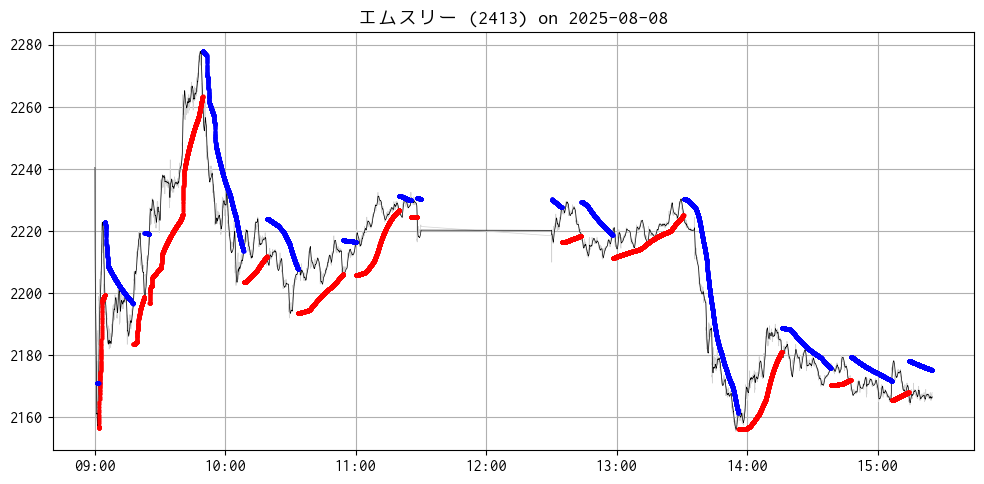

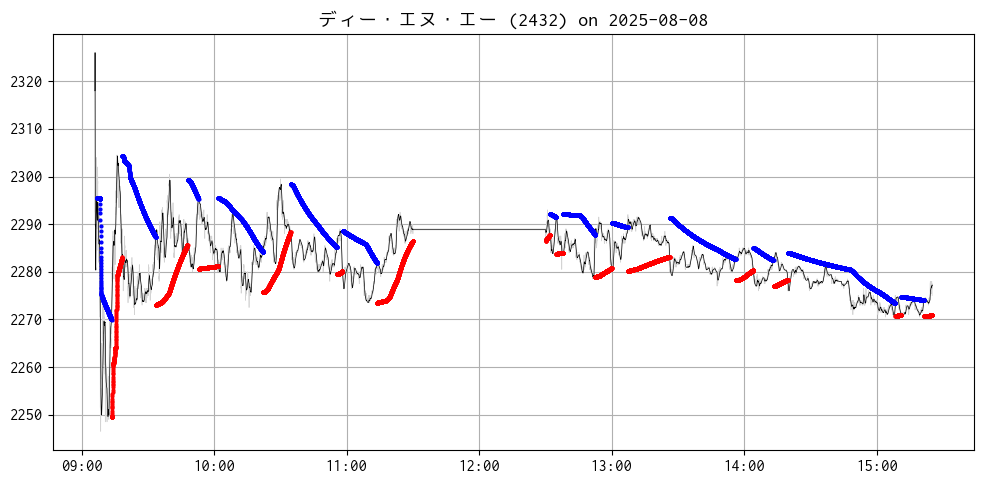

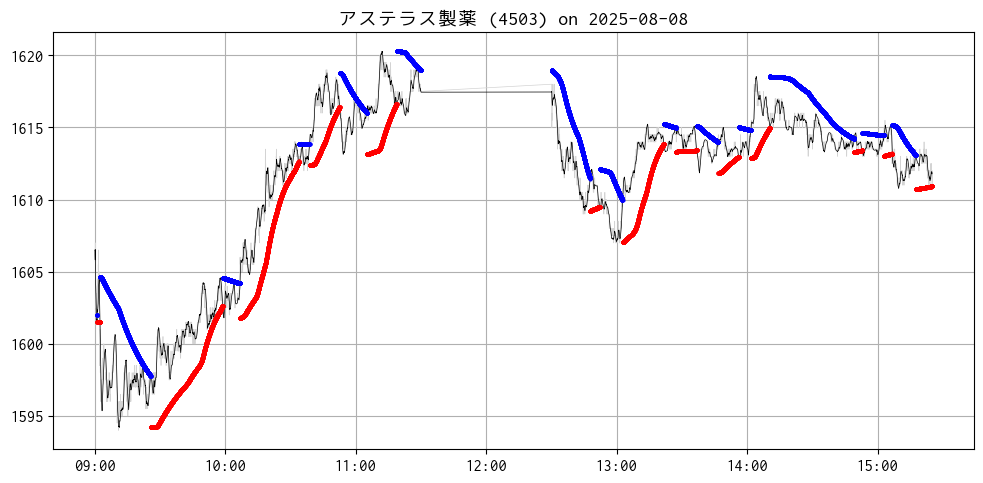

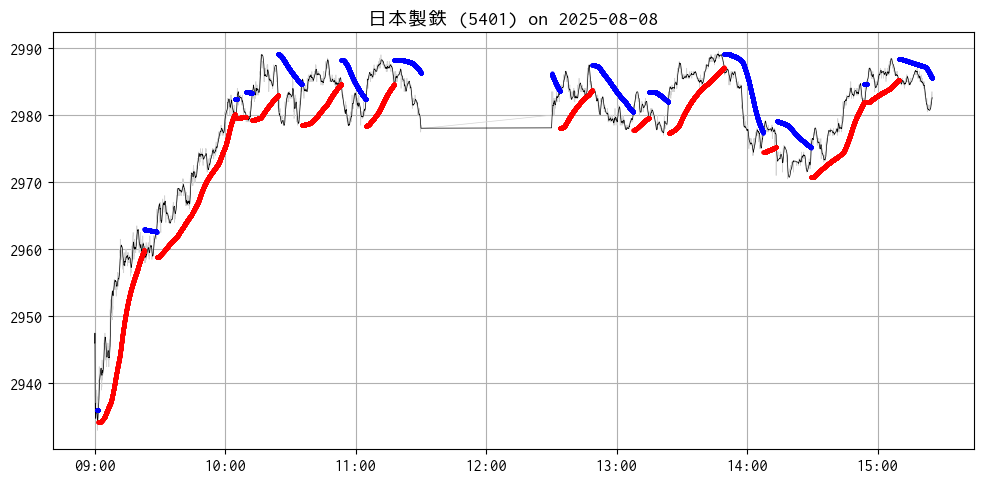

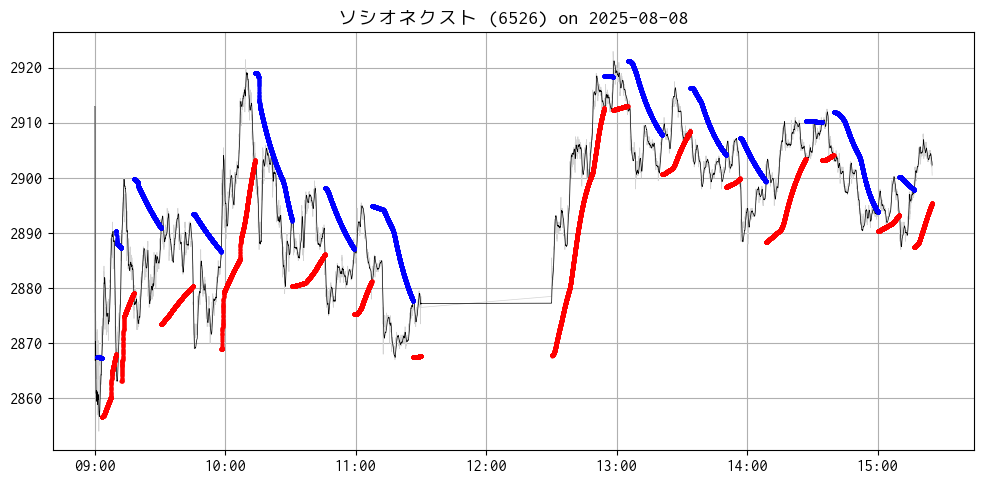

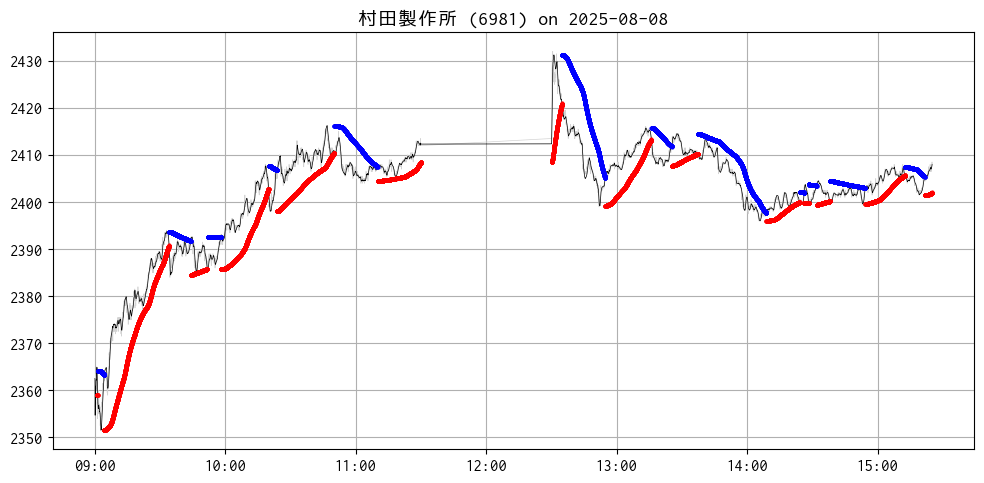

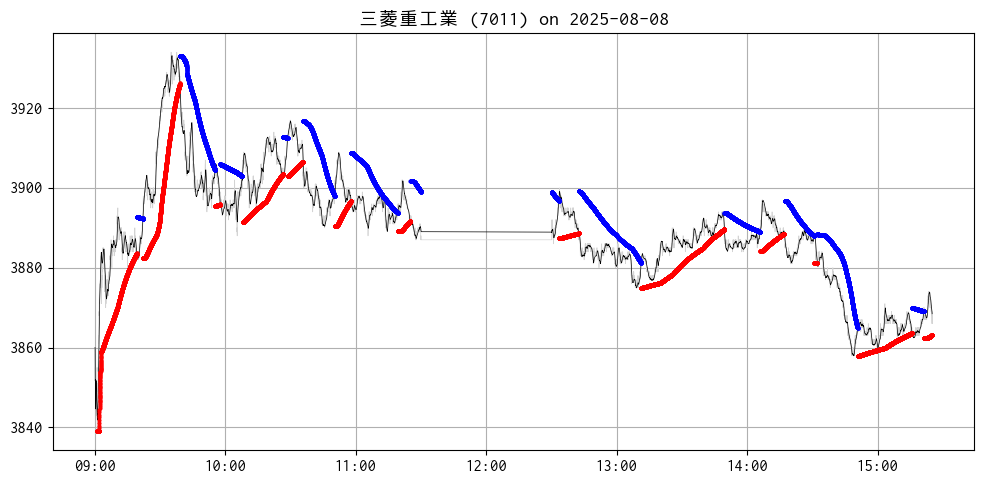

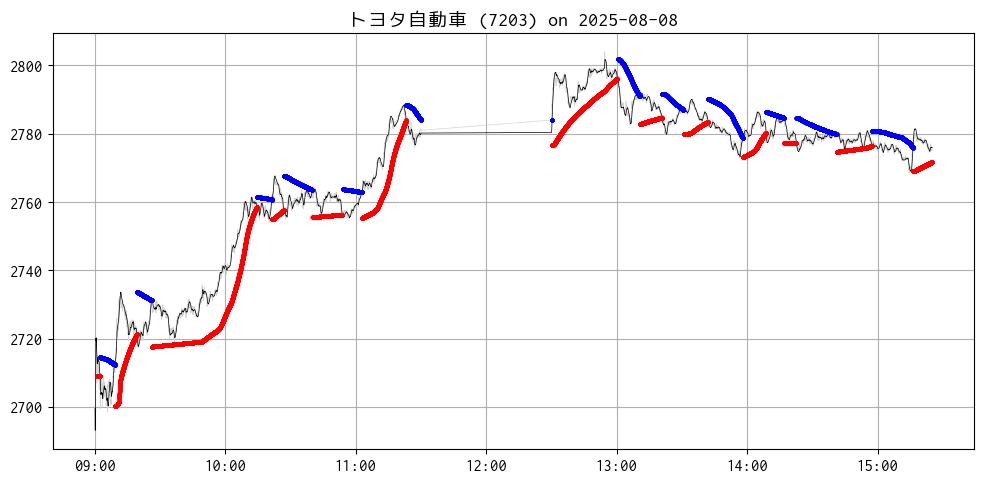

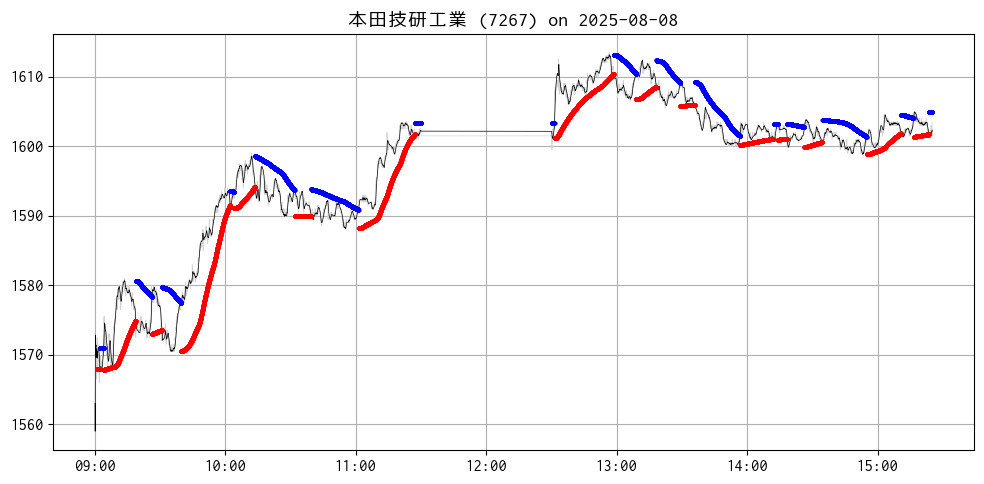

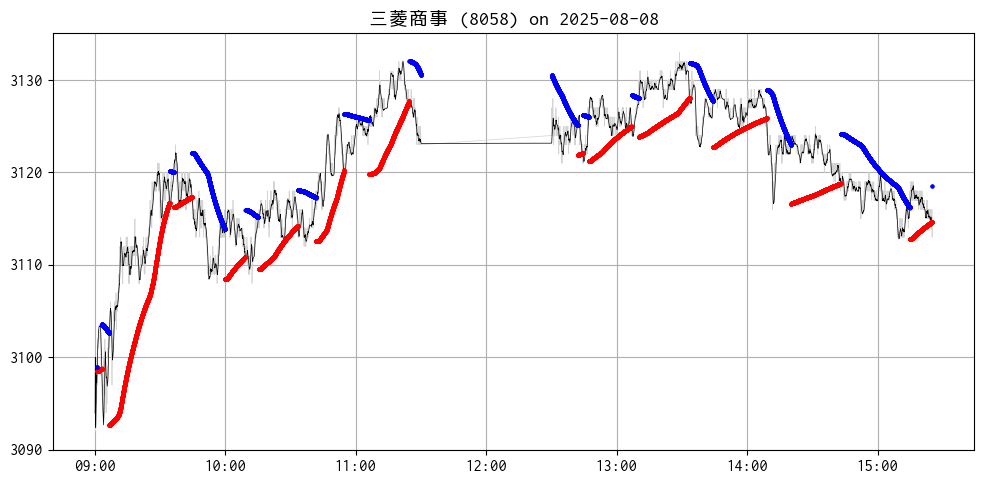

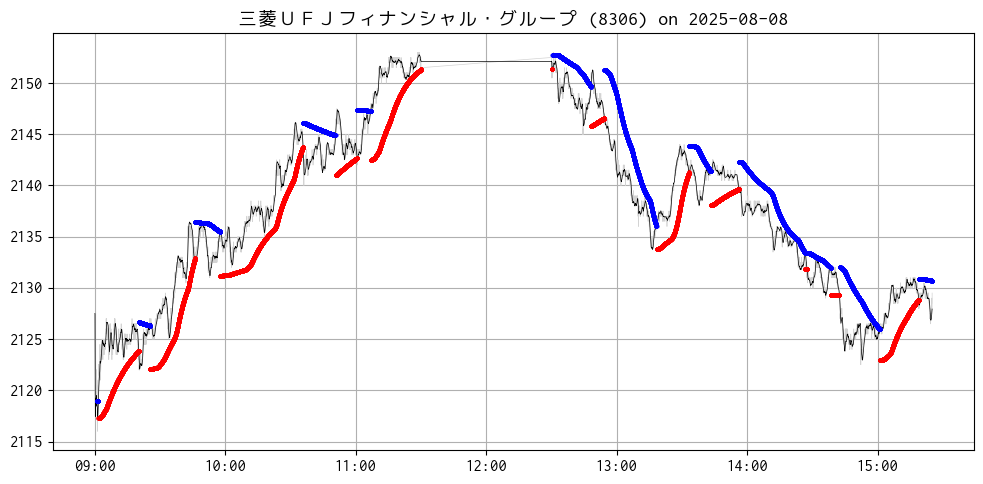

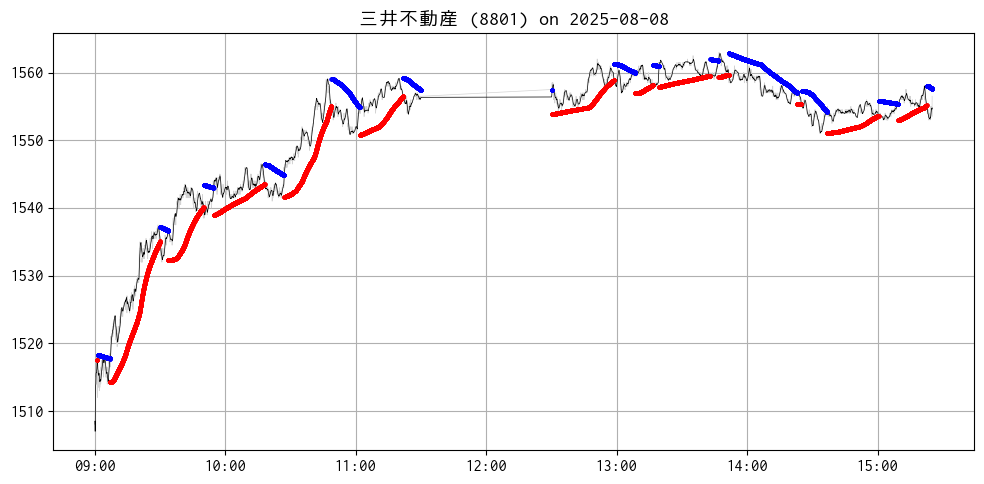

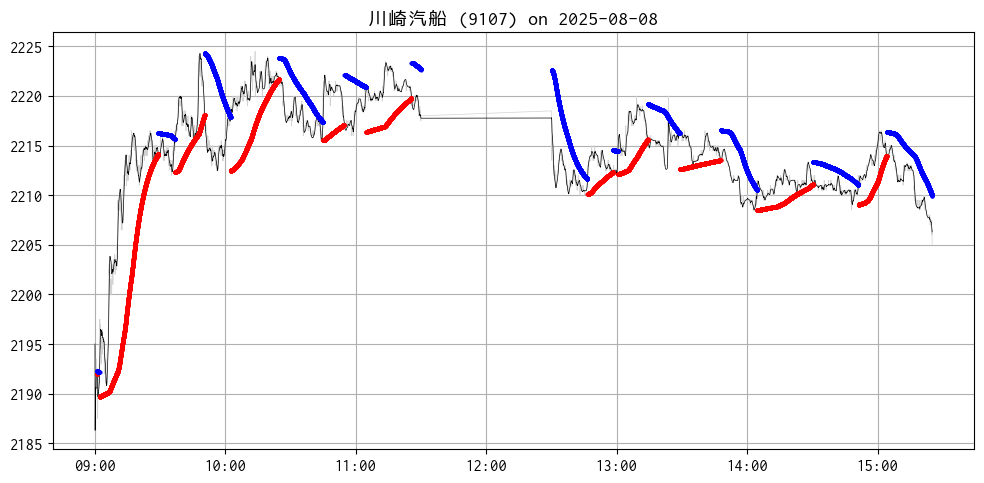

In [6]:
for sheet in list_sheet:
    df_sheet = pd.read_excel(file_excel, sheet_name=sheet)
    dict_psar = get_default_psar_params()
    psar = RealtimePSAR(dict_psar)
    df = pd.DataFrame(
        {
            "Time": [],
            "Price": [],
            "ys": [],
            "Trend": [],
            "PSAR": [],
        }
    )
    for r0 in df_sheet.index:
        ts = df_sheet.at[r0, "Time"]
        price = df_sheet.at[r0, "Price"]
        ret = psar.add(price)
        r1 = len(df)
        df.at[r1, "Time"] = ts
        df.at[r1, "Price"] = price
        df.at[r1, "ys"] = ret.ys
        df.at[r1, "Trend"] = ret.trend
        df.at[r1, "PSAR"] = ret.psar
    df.index = pd.to_datetime([datetime.datetime.fromtimestamp(t) for t in df["Time"]])
    gen_chart(sheet, date_str, path_output)